### 2 Clean Data

In [1]:
import pandas as pd
import numpy as np
import statistics
import datetime
from sklearn import preprocessing

from pyensae.graphhelper import Corrplot

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt 
 
from sklearn.decomposition import PCA


In [2]:
bt = pd.read_csv("bank_transactions.csv")      # Import the dataset
bt.dropna(inplace=True)                      # Dropping missing values 

In [3]:
# convert to timedate
bt.CustomerDOB = pd.to_datetime(bt.CustomerDOB)
bt.TransactionDate = pd.to_datetime(bt.TransactionDate)

In [4]:
def zeros(x):
    l = len(x)
    if l != 6:
        x = '0' * (6-l) + x
    return x

In [5]:
bt.TransactionTime = list(map(str,bt.TransactionTime))
bt.TransactionTime = list(map(zeros,bt.TransactionTime))
bt.TransactionTime = bt.TransactionTime.apply(lambda x: f'{x[:2]}:{x[2:4]}:{x[4:]}')
bt.TransactionTime = pd.to_datetime(bt.TransactionTime, format='%H:%M:%S')

In [6]:
bt.loc[bt.CustomerDOB.dt.year > 2000, 'CustomerDOB'] = bt.loc[bt.CustomerDOB.dt.year > 2000, 'CustomerDOB'] - pd.DateOffset(years = 100)
bt.drop(bt[bt.CustomerDOB.dt.year == 1800].index, axis=0, inplace=True)

In [7]:
#calculating customer age
bt['CustomerAge'] = (( pd.to_datetime('today') - bt.CustomerDOB ) / np.timedelta64(1, 'Y')).round(0)
bt['CustomerAge'] = bt['CustomerAge'].astype(int)

In [8]:
bt['TransactionAmount (INR)'] = bt['TransactionAmount (INR)'].astype(int)
bt['Utilisation'] = bt['CustAccountBalance'] - bt['TransactionAmount (INR)']

In [9]:
#create new key:
#bt["NewID"] = bt["CustomerID"] + "-" + bt["CustomerDOB"].astype(str)

In [10]:
#to save
bt.to_pickle("bank.pkl")

In [2]:
#to load
bt = pd.read_pickle("bank.pkl")

### 2.1 Getting your data + feature engineering

In [ ]:
#Define an empty dataframe
Features = pd.DataFrame(data=None, index=None, columns=None, dtype=None, copy=False)

#Number of transaction
Features["Num_of_Transaction"] = bt[["CustomerID","TransactionID"]].groupby("CustomerID").count()

#Transaction with balance > 100:
Features["Balance>100_USD"] = bt[["CustomerID","CustAccountBalance"]].groupby("CustomerID")["CustAccountBalance"].apply(lambda x: (x>100).sum())


#Average Amount of the transactions:
Features["Average_Amount"] = bt[["CustomerID","TransactionAmount (INR)"]].groupby("CustomerID").agg(Average_Amount=("TransactionAmount (INR)",np.mean))


#Average Balance:
Features["Average_Balance"] = bt[["CustomerID","CustAccountBalance"]].groupby("CustomerID").agg(Average_Balance=("CustAccountBalance",np.mean))


#Utilisation = Average difference between the balance and the transaction amount:
pd.options.mode.chained_assignment = None      #Avoid the red banner
bt["Utilisation"] = bt["CustAccountBalance"]-bt["TransactionAmount (INR)"]  #create "Utilisation" column
Features["Utilisation"] = bt[["CustomerID","Utilisation"]].groupby("CustomerID").agg(Utilisation=("Utilisation",np.mean))  #calculate the mean  

#Mode od Gender of the customer:  
Features["gender"]=bt[["CustomerID","CustGender"]].groupby("CustomerID").agg(CustGender =("CustGender",statistics.mode))

#Most frequent location of the customer
Features["Most_Frequent_Location"] = bt[["CustomerID","CustLocation"]].groupby("CustomerID").agg(CustLocation =("CustLocation",statistics.mode))


In [13]:
#save
Features.to_pickle("bankf.pkl")

In [36]:
#load
Features = pd.read_pickle("bankf.pkl")

### Adding 20 additional features

* 1 Customer age
* 2 Maximum transaction of the customer
* 3 Minimun transaction of the customer
* 4 Important customer (Define as Average_Balance greater than 90% of the average balance of all customers
* 5 Number of Teen agers : number of teen ager (Define  20 years before the last transaction registered )
* 6 Class Age ( young <= 25 ; 26 < grown-up <= 60  ; elderly > 60 )
* 7 Transaction with balance < 80:
* 8 Date of birth of the costumer
* 9 Maximum Balance : the maximum balance value that a custumer has
* 10 Minimum Balance : the minimum balance value that a custumer has
* 11 Average transaction
* 12 Number of man
* 13 Number of woman





In [143]:
Features["Number_of_woman"] = bt[["CustomerID","CustGender", "TransactionAmount (INR)" ]].groupby("CustomerID")["CustGender"].apply(lambda x: (x == "F").sum())
Features["Number_of_man"] = bt[["CustomerID","CustGender", "TransactionAmount (INR)" ]].groupby("CustomerID")["CustGender"].apply(lambda x: (x == "M").sum())


In [144]:
Features

,Num_of_Transaction,Balance>100_USD,Average_Amount,Average_Balance,Utilisation,gender,Most_Frequent_Location,Costumer_age,Max_transaction,Min_transaction,Number_of_teenager,Date_of_birth,Maximum_balance,Median_transaction,Minimum_balance,Average_Balance_norm,Average_amount_norm,Balance<80_USD,Number_of_woman,Number_of_man
CustomerID,,,,,,,,,,,,,,,,,,,,
C1010011,2,2,2553.0,76340.635,73787.635,F,NOIDA,40,4750,356,0,1983-05-08,120180.54,2553.0,32500.73,0.000664,0.001637,0,1,1
C1010012,1,1,1499.0,24204.490,22705.490,M,MUMBAI,28,1499,1499,0,1994-07-28,24204.49,1499.0,24204.49,0.000210,0.000961,0,0,1
C1010014,2,2,727.5,100112.950,99385.450,F,MUMBAI,38,1205,250,0,1984-08-19,161848.76,727.5,38377.14,0.000870,0.000466,0,1,1
C1010018,1,1,30.0,496.180,466.180,F,CHAMPARAN,33,30,30,0,1990-05-29,496.18,30.0,496.18,0.000004,0.000019,0,1,0
C1010024,1,1,5000.0,87058.650,82058.650,M,KOLKATA,57,5000,5000,0,1965-06-21,87058.65,5000.0,87058.65,0.000757,0.003205,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C9099836,1,1,691.0,133067.230,132376.230,M,BHIWANDI,32,691,691,0,1990-12-24,133067.23,691.0,133067.23,0.001157,0.000443,0,0,1
C9099877,1,1,222.0,96063.460,95841.460,M,BANGALORE,26,222,222,0,1996-09-06,96063.46,222.0,96063.46,0.000835,0.000142,0,0,1
C9099919,1,1,126.0,5559.750,5433.750,M,GUNTUR,29,126,126,0,1993-10-21,5559.75,126.0,5559.75,0.000048,0.000081,0,0,1


In [ ]:
Features["Number_of_woman"] = bt[["CustomerID","CustGender", "TransactionAmount (INR)" ]].groupby("CustomerID").apply(lambda x:  if x[0] == "F"  sum(x[1]) )

In [38]:
Features["Costumer_age"] = bt[["CustomerID","CustomerAge"]].groupby("CustomerID").last()

In [39]:
Features["Max_transaction"] = bt[["CustomerID","TransactionAmount (INR)"]].groupby("CustomerID").max()

In [40]:
Features["Min_transaction"] = bt[["CustomerID","TransactionAmount (INR)"]].groupby("CustomerID").min()

In [11]:
Features["Important_costumer"] = Features["Average_Balance"] > Features["Average_Balance"].quantile(.9)

In [23]:
# Qua si è settata la data dopo la quale le persone nate dopo sono teen ager
d1 = datetime.datetime(max(bt.TransactionDate).year - 20 ,max(bt.TransactionDate).month , max(bt.TransactionDate).day)
bt['teen'] = bt.CustomerDOB > d1
# Creazione della variabile
Features["Number_of_teenager"] = bt[["CustomerID","teen"]].groupby("CustomerID").agg(teen =("teen", sum )) 


In [13]:
# Copia di una varaibile che sarà modificata
Features["Class_Age"]  = Features["Costumer_age"]

# Set una singola età per ogni classe

Features.Class_Age[ (Features["Class_Age"] > 25) &  (Features["Class_Age"] <= 60) ]   = 50
Features.Class_Age[ Features["Class_Age"] <= 25]  = 20
Features.Class_Age[ Features["Class_Age"] > 60 ]  = 70

#Creazione della classe

Features.Class_Age[ Features["Class_Age"] == 20 ]  = "young"
Features.Class_Age[ Features["Class_Age"] == 50 ]  = "adult"
Features.Class_Age[ Features["Class_Age"] == 50 ]  = "elderly"




/var/folders/5c/xp7pml6x75x32v16v990ccwc0000gn/T/ipykernel_1001/734202608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Features.Class_Age[ (Features["Class_Age"] > 25) &  (Features["Class_Age"] <= 60) ]   = 50
/var/folders/5c/xp7pml6x75x32v16v990ccwc0000gn/T/ipykernel_1001/734202608.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Features.Class_Age[ Features["Class_Age"] <= 25]  = 20
/var/folders/5c/xp7pml6x75x32v16v990ccwc0000gn/T/ipykernel_1001/734202608.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyd

In [109]:
#Transaction with balance < 50:

Features["Balance<80_USD"] = bt[["CustomerID","CustAccountBalance"]].groupby("CustomerID")["CustAccountBalance"].apply(lambda x: (x<80).sum())


In [61]:
Features["Date_of_birth"] = bt[["CustomerID","CustomerDOB"]].groupby("CustomerID").last()

In [62]:
Features["Maximum_balance"] = bt[["CustomerID","CustAccountBalance"]].groupby("CustomerID").agg(Average_Balance=("CustAccountBalance",np.max))

In [63]:
Features["Median_transaction"] = bt[["CustomerID","TransactionAmount (INR)"]].groupby("CustomerID").median()

In [64]:
Features

,Num_of_Transaction,Balance>100_USD,Average_Amount,Average_Balance,Utilisation,gender,Most_Frequent_Location,Costumer_age,Max_transaction,Min_transaction,Number_of_teenager,Date_of_birth,Maximum_balance,Median_transaction
CustomerID,,,,,,,,,,,,,,
C1010011,2,2,2553.0,76340.635,73787.635,F,NOIDA,40,4750,356,0,1983-05-08,120180.54,2553.0
C1010012,1,1,1499.0,24204.490,22705.490,M,MUMBAI,28,1499,1499,0,1994-07-28,24204.49,1499.0
C1010014,2,2,727.5,100112.950,99385.450,F,MUMBAI,38,1205,250,0,1984-08-19,161848.76,727.5
C1010018,1,1,30.0,496.180,466.180,F,CHAMPARAN,33,30,30,0,1990-05-29,496.18,30.0
C1010024,1,1,5000.0,87058.650,82058.650,M,KOLKATA,57,5000,5000,0,1965-06-21,87058.65,5000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C9099836,1,1,691.0,133067.230,132376.230,M,BHIWANDI,32,691,691,0,1990-12-24,133067.23,691.0
C9099877,1,1,222.0,96063.460,95841.460,M,BANGALORE,26,222,222,0,1996-09-06,96063.46,222.0
C9099919,1,1,126.0,5559.750,5433.750,M,GUNTUR,29,126,126,0,1993-10-21,5559.75,126.0


In [65]:
Features["Minimum_balance"] = bt[["CustomerID","CustAccountBalance"]].groupby("CustomerID").agg(Average_Balance=("CustAccountBalance",np.min))

### 2 Clean Data

## 2.2 Choose your features (variables)!


In [25]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() 
arr_scaled = scaler.fit_transform([Features.Utilisation.values]) 

In [26]:
Features.Important_costumer.reset_index().Important_costumer.values

array([False, False, False, ..., False, False, False])

In [27]:
# Principal component analysis (PCA) allows us to summarize and to visualize the information 
# in a data set containing individuals/observations described by multiple inter-correlated 
# quantitative variables. Each variable could be considered as a different dimension. If you 
# have more than 3 variables in your data sets, it could be very difficult to visualize a 
# multidimensional hyperspace.
# 
# Principal component analysis is used to extract the important information from a multivariate 
# data table and to express this information as a set of few new variables called principal 
# components. These new variables correspond to a linear combination of the originals. The 
# number of principal components is less than or equal to the number of original variables.
# 
# The information in a given data set corresponds to the total variation it contains. The goal 
# of PCA is to identify directions (or principal components) along which the variation in the 
# data is maximal.
# 
# In other words, PCA reduces the dimensionality of a multivariate quantitative dataset to a fewer number of 
# principal components, that can be visualized graphically, with minimal loss of information.


In [28]:
Features

,Num_of_Transaction,Balance>100_USD,Average_Amount,Average_Balance,Utilisation,gender,Most_Frequent_Location,Costumer_age,Max_transaction,Min_transaction,teen_ager,Important_costumer,Class_Age,Balance<50_USD,Date_of_birth,Minimum_balance,Maximum_balance
CustomerID,,,,,,,,,,,,,,,,,
C1010011,2,2,2553.0,76340.635,73787.635,F,NOIDA,40,4750,356,False,False,adult,0,1983-05-08,32500.73,32500.73
C1010012,1,1,1499.0,24204.490,22705.490,M,MUMBAI,28,1499,1499,False,False,adult,0,1994-07-28,24204.49,24204.49
C1010014,2,2,727.5,100112.950,99385.450,F,MUMBAI,38,1205,250,False,False,adult,0,1984-08-19,38377.14,38377.14
C1010018,1,1,30.0,496.180,466.180,F,CHAMPARAN,33,30,30,False,False,adult,0,1990-05-29,496.18,496.18
C1010024,1,1,5000.0,87058.650,82058.650,M,KOLKATA,57,5000,5000,False,False,adult,0,1965-06-21,87058.65,87058.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C9099836,1,1,691.0,133067.230,132376.230,M,BHIWANDI,32,691,691,False,False,adult,0,1990-12-24,133067.23,133067.23
C9099877,1,1,222.0,96063.460,95841.460,M,BANGALORE,26,222,222,False,False,adult,0,1996-09-06,96063.46,96063.46
C9099919,1,1,126.0,5559.750,5433.750,M,GUNTUR,29,126,126,False,False,adult,0,1993-10-21,5559.75,5559.75


In [111]:
Features["Balance<80_USD"] = bt[["CustomerID","CustAccountBalance"]].groupby("CustomerID")["CustAccountBalance"].apply(lambda x: (x<80).sum())

In [112]:
Features

,Num_of_Transaction,Balance>100_USD,Average_Amount,Average_Balance,Utilisation,gender,Most_Frequent_Location,Costumer_age,Max_transaction,Min_transaction,Number_of_teenager,Date_of_birth,Maximum_balance,Median_transaction,Minimum_balance,Average_Balance_norm,Average_amount_norm,Balance<80_USD
CustomerID,,,,,,,,,,,,,,,,,,
C1010011,2,2,2553.0,76340.635,73787.635,F,NOIDA,40,4750,356,0,1983-05-08,120180.54,2553.0,32500.73,0.000664,0.001637,0
C1010012,1,1,1499.0,24204.490,22705.490,M,MUMBAI,28,1499,1499,0,1994-07-28,24204.49,1499.0,24204.49,0.000210,0.000961,0
C1010014,2,2,727.5,100112.950,99385.450,F,MUMBAI,38,1205,250,0,1984-08-19,161848.76,727.5,38377.14,0.000870,0.000466,0
C1010018,1,1,30.0,496.180,466.180,F,CHAMPARAN,33,30,30,0,1990-05-29,496.18,30.0,496.18,0.000004,0.000019,0
C1010024,1,1,5000.0,87058.650,82058.650,M,KOLKATA,57,5000,5000,0,1965-06-21,87058.65,5000.0,87058.65,0.000757,0.003205,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C9099836,1,1,691.0,133067.230,132376.230,M,BHIWANDI,32,691,691,0,1990-12-24,133067.23,691.0,133067.23,0.001157,0.000443,0
C9099877,1,1,222.0,96063.460,95841.460,M,BANGALORE,26,222,222,0,1996-09-06,96063.46,222.0,96063.46,0.000835,0.000142,0
C9099919,1,1,126.0,5559.750,5433.750,M,GUNTUR,29,126,126,0,1993-10-21,5559.75,126.0,5559.75,0.000048,0.000081,0


In [110]:
Features

,Num_of_Transaction,Balance>100_USD,Average_Amount,Average_Balance,Utilisation,gender,Most_Frequent_Location,Costumer_age,Max_transaction,Min_transaction,Number_of_teenager,Date_of_birth,Maximum_balance,Median_transaction,Minimum_balance,Average_Balance_norm,Average_amount_norm
CustomerID,,,,,,,,,,,,,,,,,
C1010011,2,2,2553.0,76340.635,73787.635,F,NOIDA,40,4750,356,0,1983-05-08,120180.54,2553.0,32500.73,0.000664,0.001637
C1010012,1,1,1499.0,24204.490,22705.490,M,MUMBAI,28,1499,1499,0,1994-07-28,24204.49,1499.0,24204.49,0.000210,0.000961
C1010014,2,2,727.5,100112.950,99385.450,F,MUMBAI,38,1205,250,0,1984-08-19,161848.76,727.5,38377.14,0.000870,0.000466
C1010018,1,1,30.0,496.180,466.180,F,CHAMPARAN,33,30,30,0,1990-05-29,496.18,30.0,496.18,0.000004,0.000019
C1010024,1,1,5000.0,87058.650,82058.650,M,KOLKATA,57,5000,5000,0,1965-06-21,87058.65,5000.0,87058.65,0.000757,0.003205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C9099836,1,1,691.0,133067.230,132376.230,M,BHIWANDI,32,691,691,0,1990-12-24,133067.23,691.0,133067.23,0.001157,0.000443
C9099877,1,1,222.0,96063.460,95841.460,M,BANGALORE,26,222,222,0,1996-09-06,96063.46,222.0,96063.46,0.000835,0.000142
C9099919,1,1,126.0,5559.750,5433.750,M,GUNTUR,29,126,126,0,1993-10-21,5559.75,126.0,5559.75,0.000048,0.000081


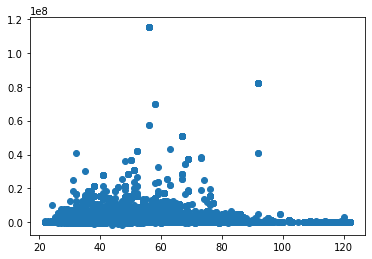

In [98]:
plt.show()

/Users/paolo/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


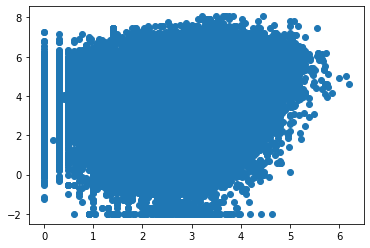

In [120]:
plt.scatter(np.log10(Features.Average_Amount), np.log10(Features.Average_Balance))
plt.show()

In [145]:
Features

,Num_of_Transaction,Balance>100_USD,Average_Amount,Average_Balance,Utilisation,gender,Most_Frequent_Location,Costumer_age,Max_transaction,Min_transaction,Number_of_teenager,Date_of_birth,Maximum_balance,Median_transaction,Minimum_balance,Average_Balance_norm,Average_amount_norm,Balance<80_USD,Number_of_woman,Number_of_man
CustomerID,,,,,,,,,,,,,,,,,,,,
C1010011,2,2,2553.0,76340.635,73787.635,F,NOIDA,40,4750,356,0,1983-05-08,120180.54,2553.0,32500.73,0.000664,0.001637,0,1,1
C1010012,1,1,1499.0,24204.490,22705.490,M,MUMBAI,28,1499,1499,0,1994-07-28,24204.49,1499.0,24204.49,0.000210,0.000961,0,0,1
C1010014,2,2,727.5,100112.950,99385.450,F,MUMBAI,38,1205,250,0,1984-08-19,161848.76,727.5,38377.14,0.000870,0.000466,0,1,1
C1010018,1,1,30.0,496.180,466.180,F,CHAMPARAN,33,30,30,0,1990-05-29,496.18,30.0,496.18,0.000004,0.000019,0,1,0
C1010024,1,1,5000.0,87058.650,82058.650,M,KOLKATA,57,5000,5000,0,1965-06-21,87058.65,5000.0,87058.65,0.000757,0.003205,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C9099836,1,1,691.0,133067.230,132376.230,M,BHIWANDI,32,691,691,0,1990-12-24,133067.23,691.0,133067.23,0.001157,0.000443,0,0,1
C9099877,1,1,222.0,96063.460,95841.460,M,BANGALORE,26,222,222,0,1996-09-06,96063.46,222.0,96063.46,0.000835,0.000142,0,0,1
C9099919,1,1,126.0,5559.750,5433.750,M,GUNTUR,29,126,126,0,1993-10-21,5559.75,126.0,5559.75,0.000048,0.000081,0,0,1


In [146]:
df = Features[["Num_of_Transaction" , "Balance>100_USD",  "Average_Amount" , "Utilisation",  "Costumer_age",  "Min_transaction" , "Number_of_teenager" , "Maximum_balance"  ,"Minimum_balance", "Balance<80_USD", "Number_of_woman" , "Number_of_man"
  ]]


/Users/paolo/opt/anaconda3/lib/python3.9/site-packages/pyensae/graphhelper/linkage.py:43: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Y = linkage(D, method=method, metric=metric)


<AxesSubplot:>

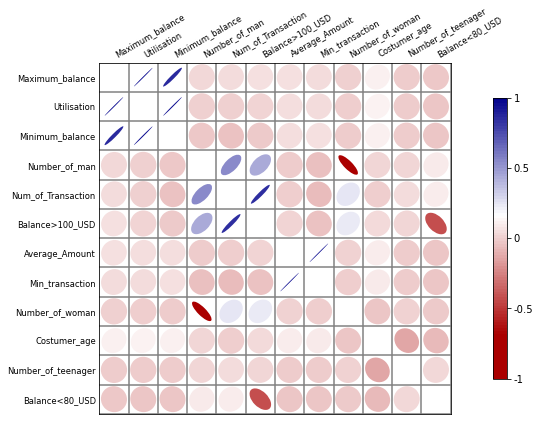

In [147]:
c = Corrplot(df)
c.plot(figsize=(12,6))

In [148]:
pca = PCA(n_components=3)
pca_features = pca.fit_transform(df)
 
print('Shape before PCA: ', df.shape)
print('Shape after PCA: ', pca_features.shape)

Shape before PCA:  (839081, 12)
Shape after PCA:  (839081, 3)


In [149]:
pca_df = pd.DataFrame(
    data=pca_features, 
    columns=[['PC1',"PC2", "PC3"]])

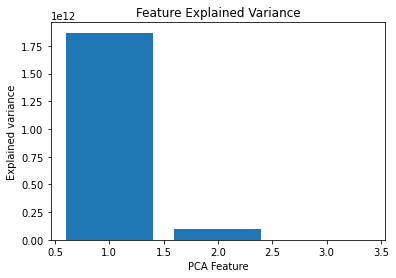

In [150]:
plt.bar(
    range(1,len(pca.explained_variance_)+1),
    pca.explained_variance_
    )
plt.xlabel('PCA Feature')
plt.ylabel('Explained variance')
plt.title('Feature Explained Variance')
plt.show()

In [ ]:
# Given a set of observations (x1, x2, ..., xn), where each observation is a d-dimensional real vector, k-means clustering aims to partition 
# the n observations into k (≤ n) sets S = {S1, S2, ..., Sk} so as to minimize the within-cluster sum of squares (WCSS) (i.e. variance).


